# Modelo de regresión simple

### Importing modules

In [1]:
!pip install plotly

In [2]:
!pip install pandas

In [3]:
!pip install matplotlib

### Task 1

In [14]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt 
import plotly.graph_objects as go
import plotly
import re
print('modules are imported')

modules are imported


### Task 1.1: 
#### Loading the Dataset: Every time the code is ran, the dataset will be upadeted

In [11]:
dataset_url = 'datos_esta.csv'
df = pd.read_csv(dataset_url)

### Task 1.2:
#### let's check the dataframe 

In [12]:
df.head()

,Temperatura_C,Temperatura_K,Fem_mV
0,169.0,442.0,2.149
1,170.0,443.0,2.170
2,171.0,444.0,2.193
3,172.0,445.0,2.214
4,173.0,446.0,2.238


In [13]:
df.tail()

,Temperatura_C,Temperatura_K,Fem_mV
205,391.0,664.0,11.135
206,392.0,665.0,11.206
207,393.0,666.0,11.257
208,394.0,667.0,11.321
209,395.0,668.0,11.383


#### let's check the shape of the dataframe 

In [9]:
df.shape

(210, 3)

### Task 2.1 :
#### let's do some preprocessing 

In [15]:
df.summary()

AttributeError: 'DataFrame' object has no attribute 'summary'

In [16]:
column_names = list(df.columns)
print(column_names)

['Temperatura_C', 'Temperatura_K', 'Fem_mV']


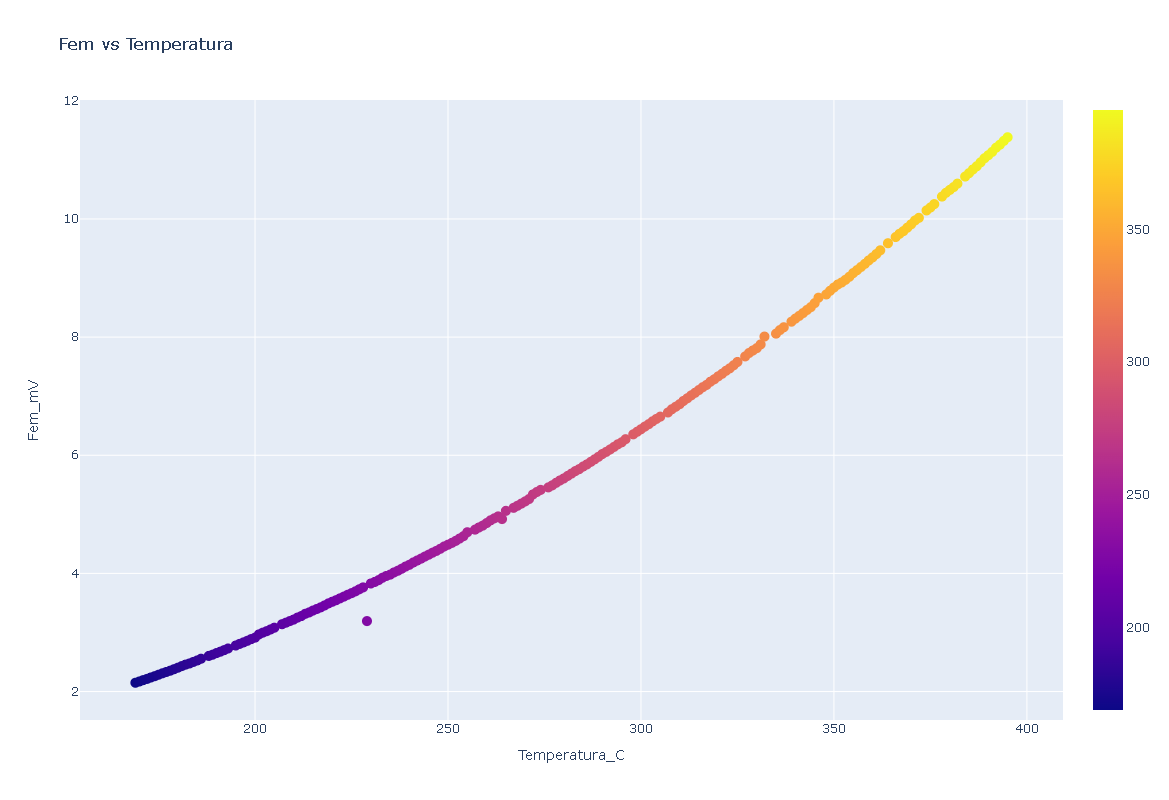

In [35]:
fig = go.Figure(
data = go.Scatter(
    x= df['Temperatura_C'],
    y = df['Fem_mV'],
    mode = 'markers',
    marker = dict(
    size = 10,
    color = df['Temperatura_C'],
    showscale = True,
    ),
    text = df['Temperatura_C']
)
)

fig.update_layout(title = 'Fem vs Temperatura'
                 , xaxis_title = 'Temperatura_C'
                 , yaxis_title = 'Fem_mV'
                 , autosize=False
                 , width=1150
                 , height=800)
fig.show()

In [22]:
df['ln_Temperatura'] = np.log(df['Temperatura_C'])
df['ln_Fem'] = np.log(df['Fem_m'])
df.head()

,Temperatura_C,Temperatura_K,Fem_mV,ln_Temperatura,ln_Fem
0,169.0,442.0,2.149,5.129899,0.765003
1,170.0,443.0,2.170,5.135798,0.774727
2,171.0,444.0,2.193,5.141664,0.785270
3,172.0,445.0,2.214,5.147494,0.794801
4,173.0,446.0,2.238,5.153292,0.805583


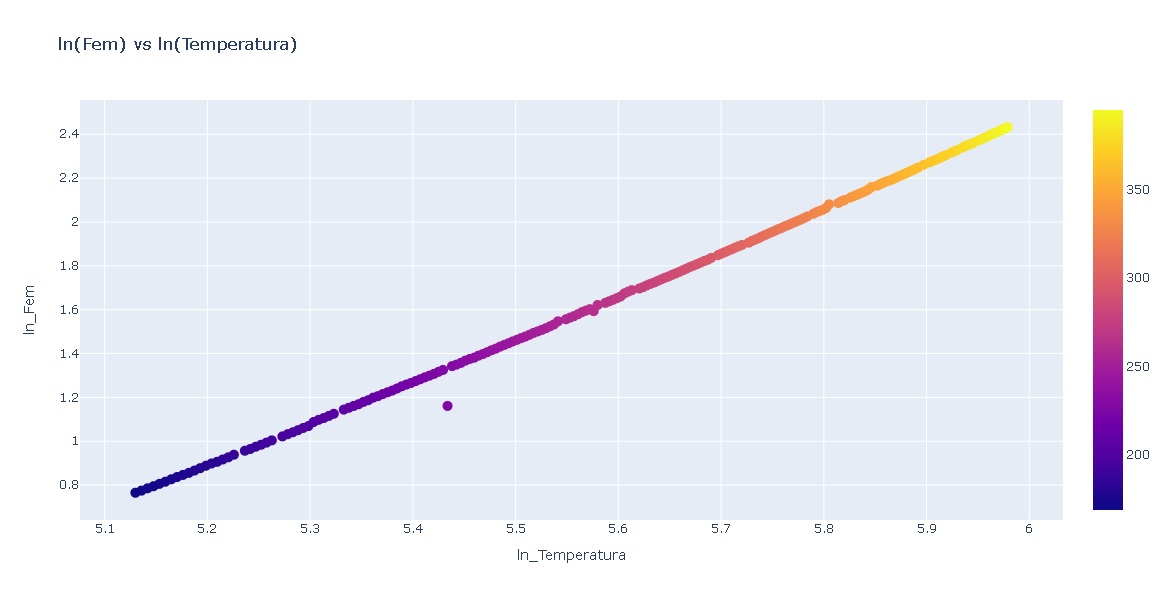

In [31]:
fig = go.Figure(
data = go.Scatter(
    x= df['ln_Temperatura'],
    y = df['ln_Fem'],
    mode = 'markers',
    marker = dict(
    size = 10,
    color = df['Temperatura_C'],
    showscale = True,
    ),
    text = df['Temperatura_C']
)
)

fig.update_layout(title = 'ln(Fem) vs ln(Temperatura)'
                 , xaxis_title = 'ln_Temperatura'
                 , yaxis_title = 'ln_Fem'
                 , autosize=False
                 , width=1150
                 , height=600)
fig.show()

#### let's see data related to a country for example Italy 


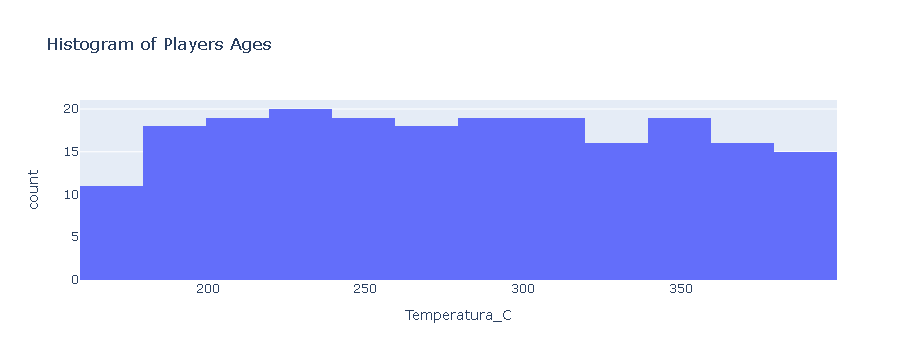

In [20]:
fig = px.histogram(df , x = 'Temperatura_C' , title = 'Histogram of Players Ages')
fig.show()